In [1]:
# 01 GAS Autoencoder

# Autoencoders for non-supervised intrusion detection

We train the autoencoders with 'normal' traffic <br>
Then detects abnormal traffic <br>
GAS dataset <br>

Training : Synthetic Data <br>
Testing  : Real Data <br>
MAE

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%matplotlib inline

2022-09-30 00:44:31.675973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-30 00:44:31.675997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
NETWORK = 'ANN'

In [4]:
def label_marker(row):
    if isinstance(row[label_name], str) and 'Natural' in row[label_name]:
        return 0
    if isinstance(row[label_name], str) and 'Attack' in row[label_name]:
        return 1
    return 

In [5]:
#path = './data/Zero_Day/'
path = './gas/'
label_name = 'result'
#path_normal = path +'VAE_syntheticdata_normal_epoch100_1000000.csv'
path_normal = path +'Normal.csv'
path_attack = path + 'Attack.csv' # real data

normal_df = pd.read_csv(path_normal)  
attack_df = pd.read_csv(path_attack)  

normal_df[label_name] = normal_df.apply(label_marker, axis=1)
attack_df[label_name] = attack_df.apply(label_marker, axis=1)

normal_label = normal_df[label_name].to_numpy() 
attack_label = attack_df[label_name].to_numpy() 

print(len(normal_label))
print(len(attack_label))

61156
35863


In [6]:
# Delete marker column 
normal_df.drop([label_name], axis=1, inplace=True)
attack_df.drop([label_name], axis=1, inplace=True)

In [7]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
normal_np = normal_df.to_numpy()
print('normal shape',normal_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (61156, 26)
attack shape (35863, 26)


In [8]:
normal_df = normal_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_df)

attack_df = attack_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
attack_scaled = scaler.fit_transform(attack_df)

In [9]:
norm_samples = normal_scaled
attack_samples = attack_scaled
print (attack_samples.shape)
print (norm_samples.shape)

(35863, 26)
(61156, 26)


In [10]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.80 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_scaled[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [11]:
#x_train = traffic_np_norm[...,np.newaxis]
#x_combine = combine_np_norm[...,np.newaxis]
#x_attack = attack_np_norm[...,np.newaxis]
print("Normal Traffic Training input shape: ", X_train.shape)
print("Combine Traffic Test input shape: ", X_test.shape)

Normal Traffic Training input shape:  (48924, 26)
Combine Traffic Test input shape:  (24464, 26)


In [12]:
input_dim = X_train.shape[1]
encoding_dim = X_train.shape[1]

def build_model_ANN():
   input_ANN = layers.Input(shape=(input_dim, ))
#   encoder = layers.Dropout(rate=0.2)(input_ANN)
   encoder = layers.Dense(1024, activation='relu')(input_ANN)
   encoder = layers.Dense(512, activation='relu')(encoder)
   encoder = layers.Dropout(rate=0.2)(encoder)
   encoder = layers.Dense(128, activation='relu')(encoder)
   encoder = layers.Dropout(rate=0.2)(encoder)
   encoder = layers.Dense(32, activation='relu')(encoder)
   decoder = layers.Dropout(rate=0.2)(encoder)
   decoder = layers.Dense(128, activation='relu')(decoder)
   decoder = layers.Dropout(rate=0.2)(decoder)
   decoder = layers.Dense(512, activation='tanh')(decoder)
   decoder = layers.Dense(1024, activation='tanh')(decoder)
   out_layer = layers.Dense(encoding_dim, activation = 'tanh')(decoder)
   autoencoder = keras.Model(inputs=input_ANN, outputs=out_layer)
   return autoencoder

def build_model_CNN():
    input_a = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
    x = layers.Conv1D(filters=512, kernel_size=7, padding="same", strides=2, activation="relu")(input_a)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=256, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=64, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Conv1DTranspose(filters=32, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=64, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=256, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=512, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    
    model = keras.Model(inputs=[input_a], outputs=output)
    
    return model

In [13]:
# We arange dimensions to work with CNN or ANN
# Remember CNN has an additional dimension at the end

keras.backend.clear_session()

if NETWORK == 'CNN':
    model = build_model_CNN()
    noise = noise[...,np.newaxis]
elif NETWORK == 'ANN':
    model = build_model_ANN()
    x_train = np.squeeze(X_train)
    x_attack = np.squeeze(X_test)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense (Dense)               (None, 1024)              27648     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                4128  

2022-09-30 00:44:34.508869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 00:44:34.509362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-30 00:44:34.509467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-30 00:44:34.509561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-30 00:44:34.512322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [14]:
#noise.shape

In [15]:
## Train the model

#Note that we are using `X_train` as both the input and the target
#since this is a reconstruction model.
#"""
#x_train_noisy = x_train + noise

history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.17,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Train on 40606 samples, validate on 8318 samples
Epoch 1/50


2022-09-30 00:44:34.993896: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


40320/40606 [============================>.] - ETA: 0s - loss: 0.0044

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


40606/40606 [==============================] - 4s 94us/sample - loss: 0.0043 - val_loss: 3.9607e-04
Epoch 2/50
40606/40606 [==============================] - 3s 83us/sample - loss: 5.2415e-04 - val_loss: 2.3167e-04
Epoch 3/50
40606/40606 [==============================] - 3s 83us/sample - loss: 3.9184e-04 - val_loss: 9.9600e-05
Epoch 4/50
40606/40606 [==============================] - 3s 82us/sample - loss: 3.1583e-04 - val_loss: 1.4530e-04
Epoch 5/50
40606/40606 [==============================] - 4s 88us/sample - loss: 3.0253e-04 - val_loss: 1.3570e-04
Epoch 6/50
40606/40606 [==============================] - 3s 85us/sample - loss: 2.8338e-04 - val_loss: 2.0335e-04
Epoch 7/50
40606/40606 [==============================] - 3s 84us/sample - loss: 2.6012e-04 - val_loss: 2.2683e-04
Epoch 8/50
40606/40606 [==============================] - 3s 82us/sample - loss: 2.4864e-04 - val_loss: 2.2821e-04


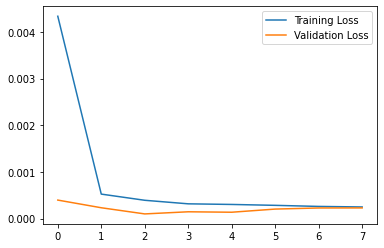

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [17]:
# we use RMSE as reconstruction error (can use MAE as well)
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [18]:
# Prediction of training vector
X_train_pred = model.predict(X_train)
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error \
      {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')

error_thresh = np.quantile(mae_vector, 0.95)
print('error threshold >>>', error_thresh)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Avg error 0.006127535405064645
median error       0.006317830655780546
99Q: 0.012287181686781374
error threshold >>> 0.009994975369626896


In [19]:
# application of error threshold in test vector
# A vector of anomalies is created with the points that go over the threshold

X_pred = model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total length vector anomalies : ',len(anomalies))
print('Number of anomalies : ', np.count_nonzero(anomalies))
print('total length of y_test vector',len(y_test))
print('total lenght of attacks in y_test vector', np.count_nonzero(y_test))

total length vector anomalies :  24464
Number of anomalies :  13109
total length of y_test vector 24464
total lenght of attacks in y_test vector 12232


In [20]:
# Sklearn classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     12232
         1.0       0.93      1.00      0.97     12232

    accuracy                           0.96     24464
   macro avg       0.97      0.96      0.96     24464
weighted avg       0.97      0.96      0.96     24464



In [21]:
# second prediction with X_test vector to be used in PCA transformation
X_pred2 = model.predict(X_test)
# PCA transformation to observe variance in 2 components

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=123)
X_transform = pca.fit_transform(X_pred2)

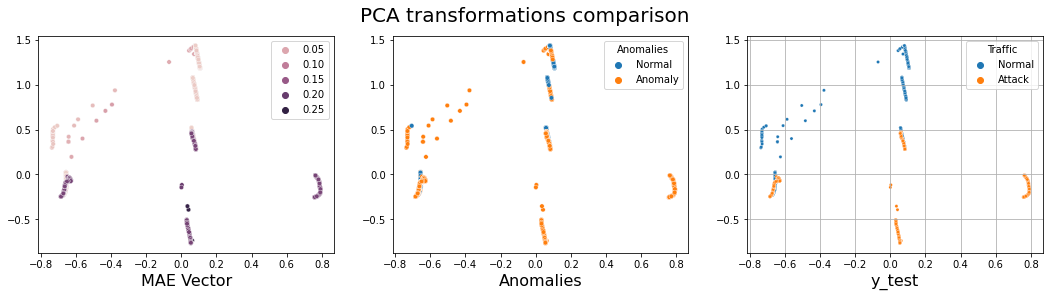

In [22]:
# Figure comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
legend_labels2, _ = ax2.get_legend_handles_labels()
ax2.legend(legend_labels2, ['Normal', 'Anomaly'], title='Anomalies')
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
legend_labels3, _ = ax3.get_legend_handles_labels()
ax3.legend(legend_labels3, ['Normal', 'Attack'], title='Traffic')
plt.grid()
plt.show()

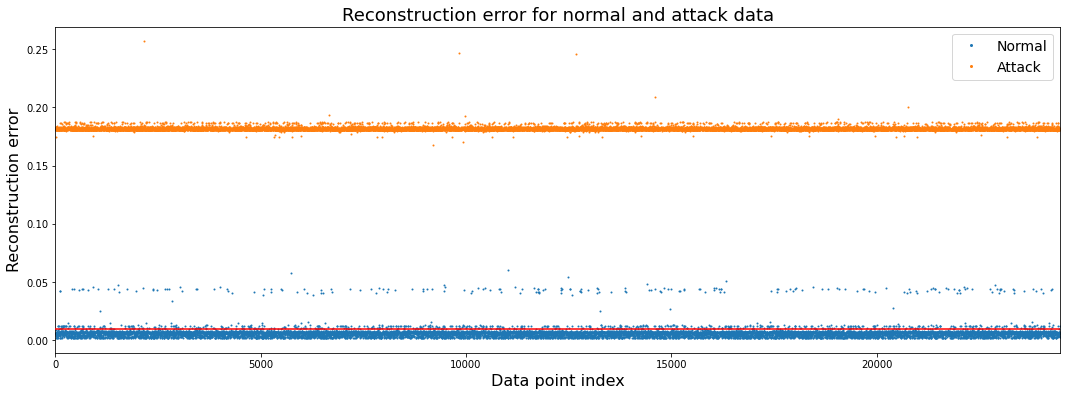

In [23]:
# Reconstruction figure
plt.rc('legend',fontsize=14)
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=1, linestyle='',
            label= "Attack" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", 
          zorder=100, label='Threshold')
plt.xlim(0,error_df.shape[0])
# leg = ax.legend()
# leg.set_title('Traffic',prop={'size':14})
legend_label, _ = ax.get_legend_handles_labels()
plt.legend(legend_label, ['Normal', 'Attack'], prop={'size': 14}, 
          loc="upper right", markerscale=2., scatterpoints=1)
plt.title("Reconstruction error for normal and attack data", size=18)
plt.ylabel("Reconstruction error", size=16)
plt.xlabel("Data point index", size = 16)
plt.show()

In [24]:
# Reconstruction errors for figure

Global_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(' Attack_error shape', Attack_error.shape, '\n', 
      'Normal_error shape', Normal_error.shape)

 Attack_error shape (12232,) 
 Normal_error shape (12232,)


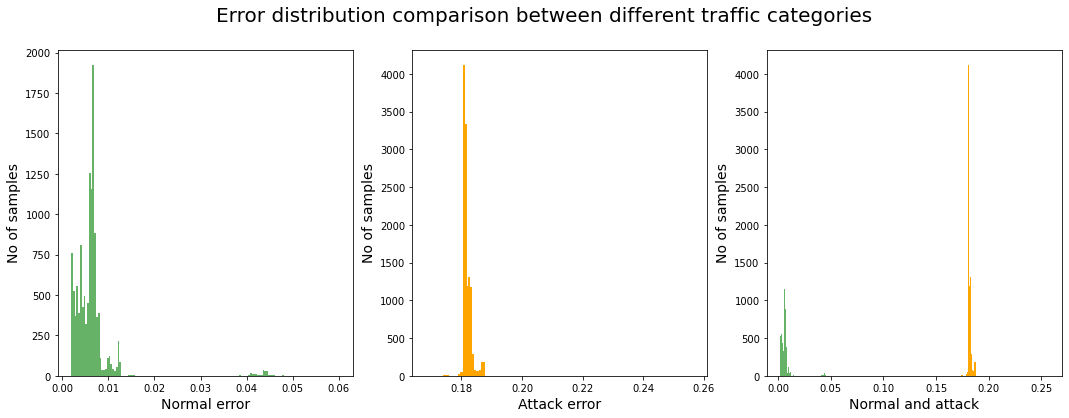

In [25]:
# Figure error distribution

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distribution comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='orange')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='orange')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

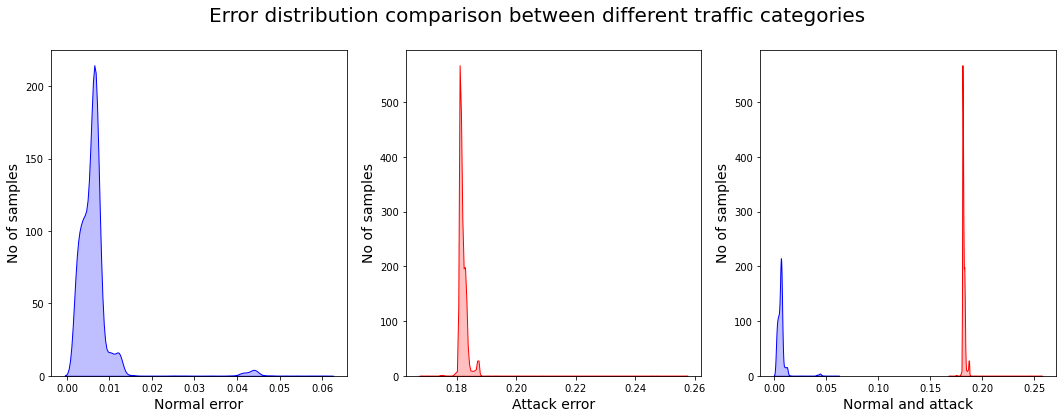

In [26]:
# Figure errors with KDE Plot

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distribution comparison between different traffic categories',
             size=20)
#ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)

sns.kdeplot(Normal_error,fill= True, ax = ax1,color   = 'blue')

ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
sns.kdeplot(Attack_error,fill= True, ax = ax2,color = 'red')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)

sns.kdeplot(Normal_error,fill= True, ax = ax3,color   = 'blue')
sns.kdeplot(Attack_error,fill= True, ax = ax3,color   = 'red')
#ax3.hist(Attack_error, bins=150, color='orange')
#ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

/home/manero/DL/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/manero/DL/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


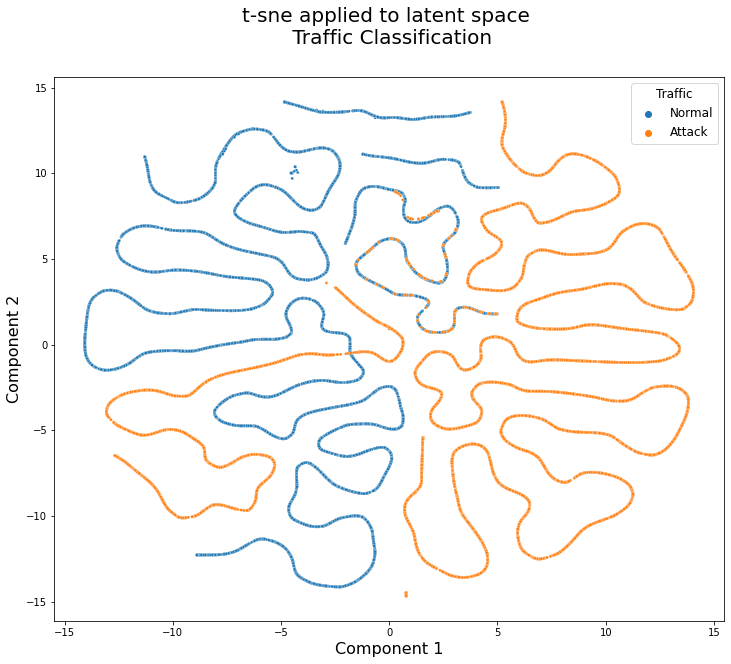

In [27]:
# Analisis latent space with t-SNE


tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, init='pca', random_state=123)
tsne_results = tsne.fit_transform(X_pred2)

df_subset=pd.DataFrame(tsne_results, columns=['tsne-2d-one','tsne-2d-two']) 

plt.rcParams['axes.titley'] = 1.05
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('t-sne applied to latent space \n Traffic Classification',size=20)
ax.set_ylabel('Component 2', size=16)
custom_cmap = LinearSegmentedColormap.from_list("", ["blue","orange"])
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=y_test,
    alpha=1,
    data=df_subset,
    cmap=custom_cmap,
    s = 8
)
ax.set_xlabel('Component 1', size=16)
legend_label, _ = ax.get_legend_handles_labels()
ax.legend(legend_label, ['Normal', 'Attack'], title='Traffic', fontsize=12, title_fontsize=12)
plt.show()

In [28]:
# t-sne transformation to observe variance in 3 components of latent space

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300, init='pca', 
            random_state=123)
tsne_results = tsne.fit_transform(X_pred2)
df_subset=pd.DataFrame(tsne_results, columns=['tsne-2d-one','tsne-2d-two', 
                                              'tsne-2d-three']) 

/home/manero/DL/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/manero/DL/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


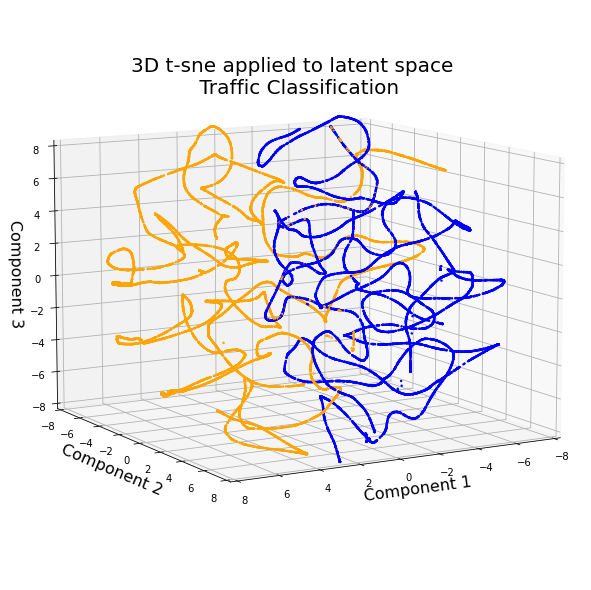

In [32]:
# t-sne figure
plt.rcParams['axes.titlepad'] = -14 
plt.rcParams['axes.titley'] = .95

fig = plt.figure(figsize=(8,8))
ax= Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.axes.set_xlim3d(left=-8, right=8)
ax.axes.set_ylim3d(bottom=-8, top=8)
ax.axes.set_zlim3d(bottom=-8, top=8)
custom_cmap = LinearSegmentedColormap.from_list("", ["blue","orange"])
sc = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2],
               c=y_test, alpha = 1, cmap=custom_cmap, s=2)
plt.title('3D t-sne applied to latent space \n Traffic Classification',size=20)

ax.set_xlabel('Component 1', size=16)
ax.set_ylabel('Component 2', size=16)
ax.set_zlabel('Component 3', size=16)
# rotate the axes and update
#fig.tight_layout()
fig.subplots_adjust(left=0, right=1, bottom=-10, top=-2)
ax.view_init(10, 60)
plt.show()

In [30]:
#EOF